In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
from datetime import datetime
import tensorflow
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [94]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


### Introduction

As stock market prices exhibit random walk (Fama, 1995), it is considered the most
challenging task to predict the magnitude and directional changes of stock prices as it has always
been a knotty problem (Meher et al., 2021). Therefore, investors always demand accurate stock
market forecasting as correct prediction about share prices ultimately facilitates them to make an
informed decision in their future investment plans.

ARIMA is currently wildely used to predict these trends. Mid to long term horizons could be predicted from past historical data. With the arrival of machne learning, even short term horizons could be predicted by adding a neural network to the ARIMA method. Among RF, SVM and ANN, ANN seemed to have delivered the best results which is why we will choose it for this study. 

This study aims to forecast Nestlé's stock price by using its daily closing price serie. To begin, we will assess weither or not the stock price can be predicted from conventional time serie models. Then, we will build our hybrid machine learning model and find the best model (with the lowest error rate and highest accuracy). Linear and non linear models will be considered. Our hope is to reach enough predictive confidence for investors to rely on our model to make successfull investments.

### Preparing the dataset for the time serie analysis

In [95]:
data = pd.read_excel('data_nestlé.xls')
df = pd.DataFrame(data)
df.dtypes

Date           datetime64[ns]
Dernier               float64
Ouv.                  float64
 Plus Haut            float64
Plus Bas              float64
Vol. ()               float64
Variation %           float64
dtype: object

In [96]:
df.isna().sum()

Date           0
Dernier        0
Ouv.           0
 Plus Haut     0
Plus Bas       0
Vol. ()        1
Variation %    0
dtype: int64

In [97]:
df = df.rename(columns={"Date": "date", "Dernier": "close", 'Ouv.':'open', ' Plus Haut':'highest', 'Plus Bas':'lowest','Vol. ()':'volume','Variation %':'variation'})

In [98]:
df.describe()

,close,open,highest,lowest,volume,variation
count,2735.000000,2735.000000,2735.000000,2735.000000,2734.000000,2735.000000
mean,84.167360,84.130801,84.686296,83.625664,5.673734,0.000316
std,19.587153,19.564659,19.760020,19.417801,3.478339,0.009777
min,52.750000,52.750000,53.150000,52.500000,1.210000,-0.068300
25%,69.400000,69.350000,69.750000,68.925000,3.920000,-0.004800
50%,77.200000,77.120000,77.500000,76.680000,5.000000,0.000200
75%,103.870000,103.760000,104.610000,102.970000,6.410000,0.005600
max,129.660000,129.500000,129.800000,128.280000,87.280000,0.059100


In [99]:
df = df.sort_values(by=['date']).reset_index(drop=True)

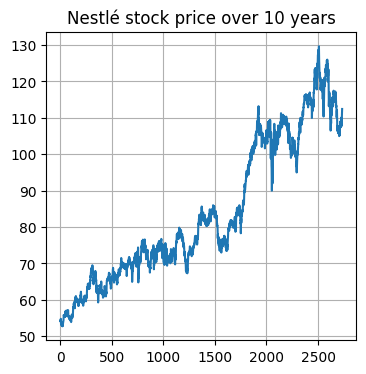

In [183]:
x = df['date']
y = df['close']
plt.figure(figsize=(4, 4))
plt.title('Nestlé stock price over 10 years')
plt.grid(True)
plt.plot(x,y)

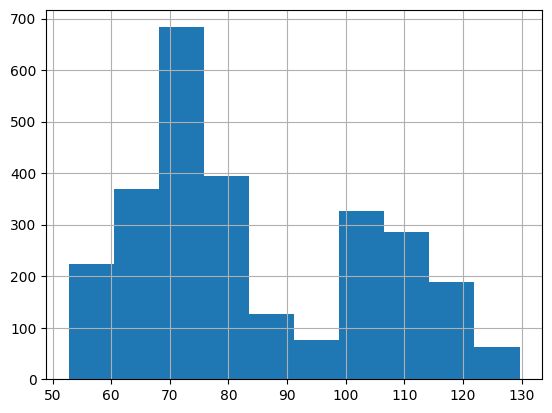

In [101]:
y.hist()
plt.show()

### Checking the stationarity of this time serie

In [102]:
# spliting the data into 5 chunks
chunks = np.split(y, indices_or_sections=5)
print(np.mean(chunks, axis=1))
print(np.var(chunks, axis=1))

[ 61.34250457  71.39296161  77.70265082  97.97808044 112.42060329]
[ 18.11759464   6.63990019  18.89990943 103.82259065  55.16800823]


In [103]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(y)

In [104]:
print(pvalue)

0.7265268573666983


We fail to reject the null hypothesis, meaning the dataset is non stationary.

#### The mean and the variance of the serie is clearly changing over time which means it isn't stationary.

### Analyzing the correlogram

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


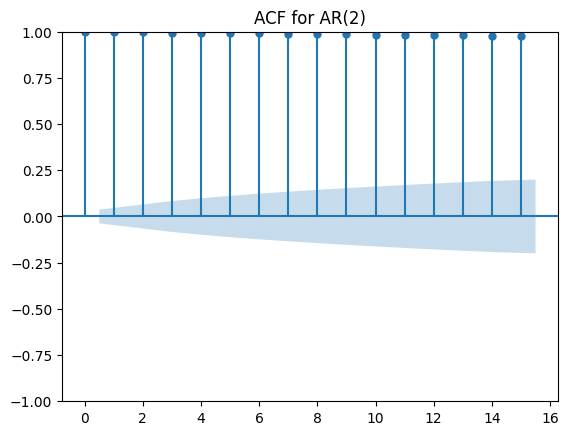

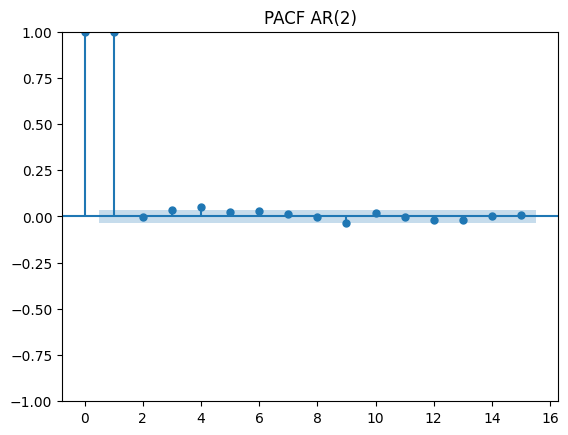

In [105]:
# Autocorrelation for AR(2)
acf_plot = plot_acf(y, lags=15, title='ACF for AR(2)')
# partial Autocorrelation for AR(2)
pacf_plot = plot_pacf(y, lags=15, title='PACF AR(2)')

#### We notice that the ACF does not gradually decrease to zero and that the PACF cuts off after lag 1, mainly due to the time serie not being stationnary. In the current state, no inference could be made on the next stock variation. 

### Decomposing the time serie

The decomposition is primarily used for time series analysis. It provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model.

The idea of multiplicative decomposition is the following:

1. Estimate the trend component $\hat{T}_{t}$ using the Moving Average.
2. Calculate the detrended series by $y_{t}/\hat{T}_{t}$.
3. Estimate the seasonal component $\hat{S}_{t}$ by calculing the simple average on the detrended series for each season.
4. Estimate the residuals component $\hat{R}_{t}$ by $\frac{y_{t}}{\hat{T}_{t}*\hat{S}_{t}}$.

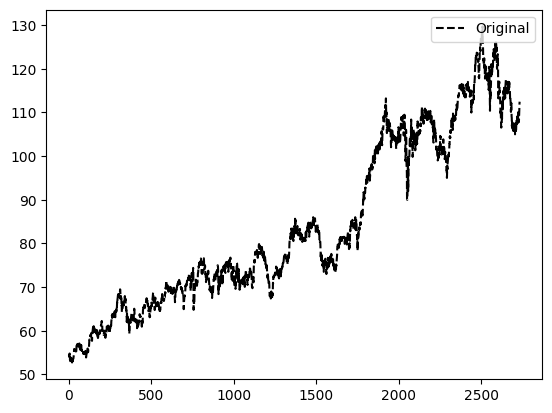

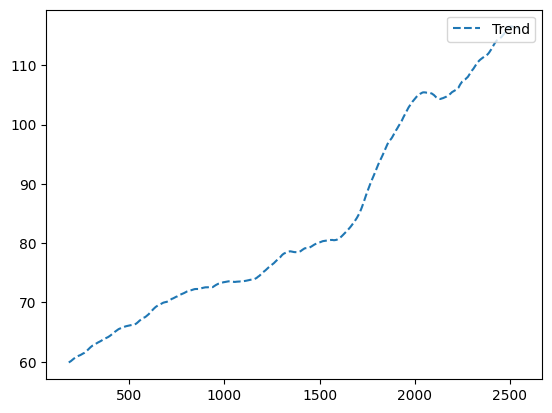

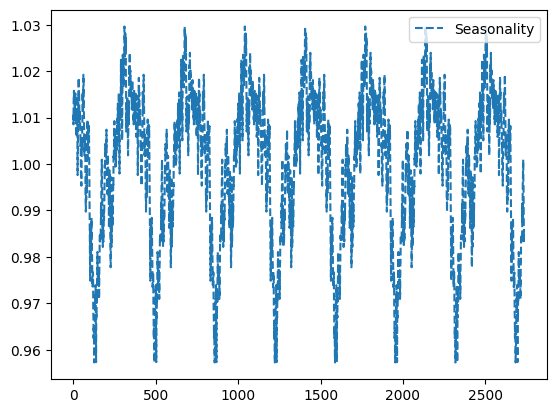

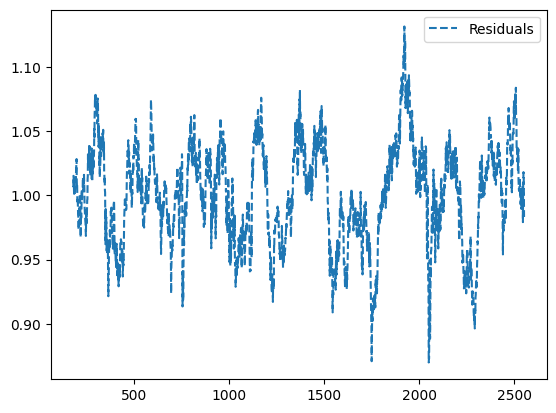

In [106]:
result = seasonal_decompose(x=y, model='multiplicative',period=365)
plt.plot(result.observed,'k',linestyle='dashed',label='Original')
plt.legend(loc='upper right')
plt.show()
plt.plot(result.trend,linestyle='dashed', label='Trend')
plt.legend(loc='upper right')
plt.show()
plt.plot(result.seasonal,linestyle='dashed', label='Seasonality')
plt.legend(loc='upper right')
plt.show()
plt.plot(result.resid,linestyle='dashed',label='Residuals')
plt.legend(loc='upper right')
plt.show()

#### The decomposition of the multiplicative model is quite representative regarding trend.

### Making the time serie stationnary

The ARMA models conbines the AR models and the MA models. The ARMA(p,q) contains the AR(p) and the MA(q) and can be used for univariate time series.

The main assumption in time series analysis is that the time series is stationary and this is not the case for many pratical situations. The solution to this can be found in the Autoregressive Integrated Moving Average(ARIMA) model. The ARIMA (p,d,q) introduces the possibility to apply differencing to the data d times in order to make it stationary. After the differenciation, the model becomes ARMA(p,q).

ARIMA is a natural extension to the class of ARMA models — they can reduce a non-stationary series to a stationary series using a sequence of differences.

ARIMA model has 3 parameters:

P — Auto regressive feature of the model

D — Differencing order

Q — Moving average feature of the model



In [178]:
# Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit()
    prediction = model_fit.forecast()
    print('Model parameters = %s' % (list(model_fit.params)))
    return prediction

In [234]:
nb_elements = len(y)
#Use 70% of data as training, rest 30% to Test model
TrainingSize = int(nb_elements * 0.7)
TrainingData = y[0:TrainingSize]
TestData = y[TrainingSize:nb_elements]

#new arrays to store actual and predictions
Actual = [x for x in TrainingData]
Test = [x for x in TestData]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(Test)):
    ActualValue =  Test[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, 2,2,1)
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    print('')
    #add it in the list
    Predictions.append(Prediction)
    print(Prediction)
    Actual.append(ActualValue)

Model parameters = [-0.012401748758041418, -0.028947396665021184, -0.9999855818127986, 0.45686519982461576]
Actual=108.080000, Predicted=107.949788

[107.94978801]
Model parameters = [-0.012260069095050664, -0.029107949283623525, -0.9998755296195249, 0.4565985713275425]
Actual=109.060000, Predicted=108.118876

[108.11887586]
Model parameters = [-0.012298833274030006, -0.029519907253083108, -0.9998525320142471, 0.4568993913492447]
Actual=109.280000, Predicted=109.072661

[109.07266149]
Model parameters = [-0.012053569361320396, -0.029414136289401416, -0.9996963719403389, 0.4567578478886196]
Actual=110.300000, Predicted=109.279489

[109.27948901]
Model parameters = [-0.011943017788577205, -0.028477765976264363, -0.9993152801839692, 0.4571681404052047]
Actual=111.000000, Predicted=110.317343

[110.31734275]
Model parameters = [-0.0112756558700899, -0.028441115905603248, -0.9990653500904608, 0.4572376060411993]
Actual=111.680000, Predicted=111.003452

[111.00345249]
Model parameters = [-0.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model parameters = [-0.010976458871482813, -0.03639942628427113, -0.9999885524474101, 0.4760098127289767]
Actual=104.160000, Predicted=104.888040

[104.8880404]
Model parameters = [-0.011785445901577245, -0.03572913545552988, -0.9999843823300156, 0.4760301850992183]
Actual=104.120000, Predicted=104.156692

[104.15669175]
Model parameters = [-0.011697138617827126, -0.03577602755077247, -0.9999371596871346, 0.47577469829692026]
Actual=104.340000, Predicted=104.171355

[104.17135459]
Model parameters = [-0.011642820083487476, -0.035849914803972226, -0.9999904389168148, 0.47557417008095804]
Actual=103.780000, Predicted=104.365488

[104.36548844]
Model parameters = [-0.011920718775719572, -0.03584169812866112, -0.9999843481640988, 0.4755055093019176]
Actual=104.640000, Predicted=103.805117

[103.805117]
Model parameters = [-0.012408421135864791, -0.035689908688305155, -0.9999317492987878, 0.4756292668532824]
Actual=103.520000, Predicted=104.676109

[104.67610853]
Model parameters = [-0.0134

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.010832321582186033, -0.0360275246660659, -0.9999763094291374, 0.608283560938167]
Actual=104.100000, Predicted=104.132006

[104.13200621]
Model parameters = [0.010991955611302761, -0.03603192218986201, -0.999936702020407, 0.6079473939669293]
Actual=102.980000, Predicted=104.208517

[104.20851676]
Model parameters = [0.010969175071320109, -0.03370515595411475, -0.9999897925752294, 0.608400199985878]
Actual=101.900000, Predicted=102.995000

[102.9950002]
Model parameters = [0.011987273678492082, -0.03367862041102079, -0.9999877733954702, 0.6086743644677494]
Actual=99.810000, Predicted=101.948139

[101.9481392]
Model parameters = [0.013806397624360575, -0.03175498888719774, -0.9999780435882296, 0.6106026228538644]
Actual=101.820000, Predicted=99.837694

[99.83769402]
Model parameters = [0.010523767157601427, -0.03342769733070924, -0.9999869979719432, 0.612185125975271]
Actual=102.780000, Predicted=101.934330

[101.93433022]
Model parameters = [0.011920220795809879, -0

Test Mean Squared Error (smaller the better fit): 1.429


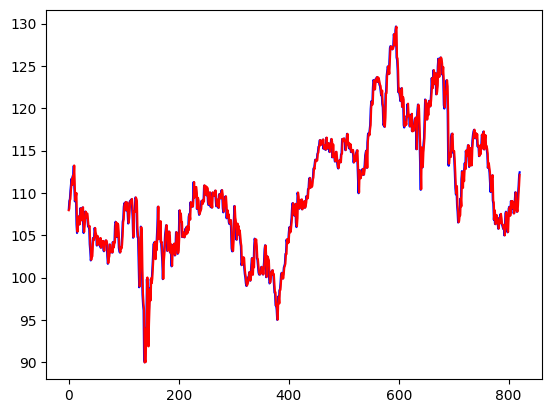

In [239]:
#Print MSE to see how good the model is
Error = mean_squared_error(Test, Predictions)
print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)
# plot
#pyplot.plot(y)
pyplot.plot(Test, color='blue')
pyplot.plot(Predictions, color='red')
pyplot.show()

#### Conclusion: 

The blue and red curves are close to one another, which translates into a low Mean Square Error of 1.429 meaning that our model's estimates are close to the actual values.

#### Further Improvements

Forecasting Nestlé's stock value can be improved by:

- Constantly updating model parameters (costly to compute)
- Inputting additional economical factors that impact stock values and their correlations into account (harder to compute)
- Model parameters can also be updated via machine learning and optimisation techniques (next step of this study)

Financial markets can move in any direction and this makes it very hard, if not impossible, to accurately predict exchange rates. Having said that, the sole purpose of forecasting exchange rates via ARIMA is to help us in taking calculated decisions that maximise returns and minimise risks. Forecasted exchange rates are dependent on the assumptions imposed by ARIMA model which are based on auto regression, integrated and moving average concepts.

ARIMA is a simple yet powerful model. It assumes that the historic values dictate behaviour of present. It also assumes that the data does not contain anomalies, is stationary and model parameters along with error term is constant.

Although ARIMA does not take stresses in market data as input (which are complexe and difficult to conceptualize) such as economical downturns and disruptives political changes, or correlations of all risk factors to forecast stock markets but the simple example demonstrated above can be useful for forecasting stable stocks in normal conditions in which past behaviour dictates present and future values.

### NN: parameter optimization (L1, L2, Sigma)